# CB_V_MAX

## Setup

In [1]:
# If necessary:
# import os
# os.remove('snorkel.db')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

## Parsing

In [3]:
os.environ['SNORKELDBNAME'] = 'polarity'
os.system("dropdb " + os.environ['SNORKELDBNAME'])
os.system("createdb " + os.environ['SNORKELDBNAME'])

0

In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

### Define Parser

In [5]:
import os
from snorkel.parser import CorpusParser, HTMLParser, OmniParser
from snorkel.utils import get_ORM_instance
from snorkel.queries import split_corpus

html_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_html/'
pdf_path  = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_pdf/'
doc_parser = HTMLParser(path=html_path)
context_parser = OmniParser(flatten=['span'], blacklist=['style'],
                            visual=True, pdf_path=pdf_path, session=session)
cp = CorpusParser(doc_parser, context_parser, max_docs=100) 

### Run Parser

In [6]:
%time corpus = cp.parse_corpus(name='Hardware', session=session)

session.add(corpus)
session.commit()

[========================================] 100%
CPU times: user 4min 23s, sys: 18.3 s, total: 4min 41s
Wall time: 10min 2s


### Split Corpus

In [7]:
from snorkel.models import Corpus

corpus = get_ORM_instance(Corpus, session, 'Hardware')
split_corpus(session, corpus, train=0.8, development=0.2, test=0, seed=9)

78 Documents added to corpus Hardware Training
19 Documents added to corpus Hardware Development


In [ ]:
# If necessary
# import os
# os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [ ]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ corpus snorkel.db');

# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

In [8]:
from snorkel.models import candidate_subclass

Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

### Define Matchers

In [9]:
from snorkel.matchers import RegexMatchSpan, Union

eeca_rgx = '([b]{1}[abcdefklnpqruyz]{1}[\swxyz]?[0-9]{3,5}[\s]?[A-Z\/]{0,5}[0-9]?[A-Z]?([-][A-Z0-9]{1,7})?([-][A-Z0-9]{1,2})?)'
eeca_matcher = RegexMatchSpan(rgx=eeca_rgx)
jedec_rgx = '([123]N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)'
jedec_matcher = RegexMatchSpan(rgx=jedec_rgx)
jis_rgx = '(2S[abcdefghjkmqrstvz]{1}[\d]{2,4})'
jis_matcher = RegexMatchSpan(rgx=jis_rgx)
others_rgx = '((NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|TIS|TIPL|DTC|MMBT|PZT){1}[\d]{2,4}[A-Z]{0,3}([-][A-Z0-9]{0,6})?([-][A-Z0-9]{0,1})?)'
others_matcher = RegexMatchSpan(rgx=others_rgx)
parts_rgx = '|'.join([eeca_rgx, jedec_rgx, jis_rgx, others_rgx])
parts_matcher = Union(eeca_matcher, jedec_matcher, jis_matcher, others_matcher)

#NOTE: This is super specific.
cb_v_matcher = RegexMatchSpan(rgx=r'\-?[2-8][0]', longest_match_only=False)

In [10]:
# import re
# part_finder = re.compile(parts_rgx, re.I)
# print any([part_finder.match(x) for x in ['blue', 'red', 'black', 'green']])
# print any([part_finder.match(x) for x in ['blue', 'red', 'BC546A', 'green']])

### Define ContextSpaces

In [11]:
import os
from collections import defaultdict
from hardware_utils import OmniNgramsPart, OmniNgramsTemp, get_gold_dict

# Make parts list
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
gold_parts = get_gold_dict(gold_file, doc_on=True, part_on=True, val_on=False)
parts_by_doc = defaultdict(set)
for part in gold_parts:
    parts_by_doc[part[0]].add(part[1])
    
part_ngrams = OmniNgramsPart(parts_by_doc=parts_by_doc, n_max=3)

# TODO: This is missing the current represented as an Amp rather than a milliamp
cb_v_ngrams = OmniNgramsTemp(n_max=3)

### Define Throttler

In [12]:
from snorkel.lf_helpers import *

def cbv_throttler((part_span, attr_span)):
    """
    Keep only those candidates where both spans are on the same page and
    either aligned in the same table (visually or structurally) or the part is global.
    """
    return(
        same_page((part_span, attr_span)) and
        (part_span.parent.table is None or
        (same_row((part_span, attr_span)) or is_horz_aligned((part_span, attr_span)))))
#     """
#     Reject any candidates whose attributes are horizontally aligned with at least one 
#     part number and are not horizontally aligned with the candidate part number
#     """
#     return not (any(part_finder.match(word) for word in get_horz_ngrams(attr_span)) and 
#         not is_horz_aligned((part_span, attr_span)))

### Run CandidateExtractor

In [13]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance


ce = CandidateExtractor(Part_Voltage, 
                        [part_ngrams, cb_v_ngrams], 
                        [parts_matcher, cb_v_matcher],
                        throttler=cbv_throttler)

for corpus_name in ['Hardware Training', 'Hardware Development']:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = ce.extract(\
        corpus.documents, corpus_name + ' Candidates', session)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

Extracting Candidates from Corpus (Hardware Training)
[========================================] 100%
CPU times: user 1min 40s, sys: 9.15 s, total: 1min 49s
Wall time: 2min 54s
Candidate Set (Hardware Training Candidates) contains 17000 Candidates
Extracting Candidates from Corpus (Hardware Development)
[========================================] 100%
CPU times: user 26.9 s, sys: 1.76 s, total: 28.7 s
Wall time: 42.2 s
Candidate Set (Hardware Development Candidates) contains 5982 Candidates


In [ ]:
# from snorkel.features.features import get_all_feats

# c = candidates[0]
# for f, _ in get_all_feats(c):
#     print f

### Assess Recall

In [14]:
from hardware_utils import entity_level_total_recall, most_common_document, get_gold_dict
from snorkel.utils import get_ORM_instance
from snorkel.models import Candidate, Corpus

all_candidates = session.query(Candidate).all()
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'

corpus = get_ORM_instance(Corpus, session, 'Hardware')
(tp, fp, fn) = entity_level_total_recall(
    all_candidates, gold_file, 'cb_v_max', corpus=corpus, relation=True, integerize=True)
print len(tp)
print len(fp)
print len(fn)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Total Recall
Entity-level Candidates extracted: 3404 
Entity-level Gold: 752
Intersection Candidates: 661
----------------------------------------
Overlap with Gold:  0.8790

661
2743
91


In [15]:
from pprint import pprint
fns = list(fn)
pprint(sorted(fns)[:10])

[('AUKCS04635-1', '2N3906', -40),
 ('DISES00490-1', 'BC846AW', 80),
 ('DISES00490-1', 'BC846BW', 80),
 ('DISES00490-1', 'BC847AW', 50),
 ('DISES00490-1', 'BC847BW', 50),
 ('DISES00490-1', 'BC847CW', 50),
 ('DISES00616-1', 'BC857', 50),
 ('DISES00616-1', 'BC857A', 50),
 ('DISES00616-1', 'BC857B', 50),
 ('DISES00616-1', 'BC857C', 50)]


In [ ]:
# If necessary
# import os
# os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [ ]:
# # If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ candidates snorkel.db');

# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

In [16]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
for set_name in ['Training', 'Development']:
    candidate_set_name = 'Hardware %s Candidates' % set_name
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % set_name
    annotation_key_name = 'Hardware %s Labels -- Gold' % set_name
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file, \
                           attrib='cb_v_max')
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

Loading 17000 candidate labels
[========================================] 100%
CPU times: user 48.3 s, sys: 1.95 s, total: 50.3 s
Wall time: 1min 1s
4503/17000 Candidates in Candidate Set (Hardware Training Candidates) have positive Labels
Loading 5982 candidate labels
[========================================] 100%
CPU times: user 17.7 s, sys: 657 ms, total: 18.4 s
Wall time: 22 s
1818/5982 Candidates in Candidate Set (Hardware Development Candidates) have positive Labels


In [ ]:
# If necessary
# import os
# os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [ ]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ labels snorkel.db');

# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

### Extract Features

In [ ]:
# from snorkel.models import CandidateSet
# from snorkel.fast_annotations import FeatureManager
# from snorkel.utils import get_ORM_instance

# train = get_ORM_instance(CandidateSet, session, 'Hardware Training Candidates')
# dev   = get_ORM_instance(CandidateSet, session, 'Hardware Development Candidates')

# feature_manager = FeatureManager()
# %time F_train = feature_manager.create(session, train, 'Train Features')
# %time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

In [47]:
from snorkel.models import CandidateSet
from snorkel.async_annotations import annotate
from snorkel.utils import get_ORM_instance

# Run batch extraction jobs
train = get_ORM_instance(CandidateSet, session, 'Hardware Training Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Development Candidates')

%time F_train = annotate(train, parallel=4)
%time F_dev = annotate(dev, parallel=4, keyset = 'Hardware Training Candidates')

print 'Training features hash:', hash(frozenset(F_train.keys)),'of length', len(F_train.keys)

Using 4 workers
CPU times: user 978 ms, sys: 167 ms, total: 1.14 s
Wall time: 1min 31s
Using 4 workers
[========================================] 100%
CPU times: user 252 ms, sys: 61.7 ms, total: 314 ms
Wall time: 28.6 s
Training features hash: 8068733309876620508 of length 13
[========================================] 100%


In [ ]:
# Integrity check for async against original feature extractor
# from snorkel.models.annotation import AnnotationKeySet
# sync_keyset = session.query(AnnotationKeySet).filter(AnnotationKeySet.name=='Train Features').one()
# print 'Async extractor extracted the same set of features as the original impl:',set(key.name for key in sync_keyset) == set(F_train.keys)

In [ ]:
# If necessary:
# import os
# os.system('cp snorkel.db snorkel.db\ featurized');

## LFs

In [ ]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ featurized snorkel.db');

# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])
# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Development Candidates').one()

In [18]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ candidates snorkel.db');

### Define LFs

In [19]:
from snorkel.fast_annotations import LabelManager
from snorkel.lf_helpers import *
label_manager = LabelManager()

LFs = []

###################################################################
# BOTH
###################################################################

# cb_words_individual = set(['collector', 'base', 'voltage'])
# cb_words_together = set(['collector-base', 'voltage'])
cb_words = set(['collector base', 'collector-base', 'collector - base'])
def LF_cb_keywords_all(c):
    return 1 if overlap(cb_words, get_row_ngrams(c.voltage, spread=[0,3], n_max=3)) else -1
LFs.append(LF_cb_keywords_all)

###################################################################
# POSITIVE
###################################################################
    
# pos_keys = set(['cbo', 'vcbo']) # 'value', 'rating'
# def LF_pos_keywords_in_row(c):
#     return 1 if overlap(pos_keys, get_row_ngrams(c.voltage, spread=[0,3])) else 0
# LFs.append(LF_pos_keywords_in_row)

# def LF_pos_keywords_horz(c):
#     return 1 if overlap(pos_keys, get_horz_ngrams(c.voltage)) else 0
# LFs.append(LF_pos_keywords_horz)

###################################################################
# NEGATIVE
###################################################################

eeca_rgx = '([b]{1}[abcdefklnpqruyz]{1}[\swxyz]?[0-9]{3,5}[\s]?[A-Z\/]{0,5}[0-9]?[A-Z]?([-][A-Z0-9]{1,7})?([-][A-Z0-9]{1,2})?)'
jedec_rgx = '([123]N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)'
jis_rgx = '(2S[abcdefghjkmqrstvz]{1}[\d]{2,4})'
others_rgx = '((NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|TIS|TIPL|DTC|MMBT|PZT){1}[\d]{2,4}[A-Z]{0,3}([-][A-Z0-9]{0,6})?([-][A-Z0-9]{0,1})?)'
parts_rgx = '|'.join([eeca_rgx, jedec_rgx, jis_rgx, others_rgx])
part_sniffer = re.compile(parts_rgx)
def LF_cheating_with_another_part(c):
    return -1 if (any(part_sniffer.match(x) for x in get_horz_ngrams(c.voltage)) and 
                     not is_horz_aligned(c)) else 0
LFs.append(LF_cheating_with_another_part)

# part_row_ngrams = list(get_row_ngrams(c.voltage, spread=[0,3], n_max=2))
# volt_row_ngrams = list(get_row_ngrams(c.voltage, spread=[0,3], n_max=2))
def LF_same_table_must_align(c):
    return -1 if (same_table(c) and not is_horz_aligned(c)) else 0
LFs.append(LF_same_table_must_align)

# # A good LF, but made obsolete by the throttling condition
# def LF_not_horz_aligned(c):
#     return -1 if (same_table(c) and not is_horz_aligned(c)) else 0
# LFs.append(LF_not_horz_aligned)

# def LF_voltage_not_in_table(c):
#     return -1 if c.voltage.parent.table is None else 0
# LFs.append(LF_voltage_not_in_table)

# def LF_low_table_num(c):
#     return -1 if (c.voltage.parent.table and
#         c.voltage.parent.table.position > 2) else 0
# LFs.append(LF_low_table_num)

# neg_keys = set(['continuous', 'emitter', 'cut-off', 'gain'])
# def LF_specific_neg_row_keywords(c):
#     return -1 if overlap(neg_keys, get_row_ngrams(c.voltage)) else 0
# LFs.append(LF_specific_neg_row_keywords)

# def LF_equals_in_row(c):
#     return -1 if overlap('=', get_row_ngrams(c.voltage)) else 0
# LFs.append(LF_equals_in_row)

# def LF_i_in_row(c):
#     return -1 if overlap('i', get_row_ngrams(c.voltage)) else 0
# LFs.append(LF_i_in_row)

# def LF_too_many_numbers_row(c):
#     num_numbers = list(get_row_ngrams(c.voltage, attrib="ner_tags")).count('number')
#     return -1 if num_numbers >= 4 else 0
# LFs.append(LF_too_many_numbers_row)

In [ ]:
from snorkel.models import Corpus, CandidateSet, Candidate
from snorkel.utils import get_ORM_instance
from snorkel.utils import ProgressBar
from hardware_utils import get_gold_dict, candidate_to_entity, part_error_analysis
from pdb import set_trace as t

# train = get_ORM_instance(CandidateSet, session, 'Hardware Training Candidates')
# dev = get_ORM_instance(CandidateSet, session, 'Hardware Development Candidates')
# dev_corpus = get_ORM_instance(Corpus, session, 'Hardware Development')

corpus = get_ORM_instance(Corpus, session, 'Hardware')
candidates = session.query(Candidate).all()

attribute = 'cb_v_max'
docs = [(doc.name).upper() for doc in corpus.documents] if corpus else None
gold_file = gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
gold_set = get_gold_dict(gold_file, docs=docs, 
                         doc_on=True, part_on=True, val_on=True, 
                         attrib=attribute)
print "Gold set size: %d" % len(gold_set)

heuristic_LFs_pos = [LF_cb_keywords_all]
heuristic_LFs_neg = [LF_cheating_with_another_part,
                    LF_not_horz_aligned,
                    LF_voltage_not_in_table,
                    LF_same_table_must_align,
                    LF_specific_neg_row_keywords,
                    LF_equals_in_row,
                    LF_i_in_row,
                    LF_too_many_numbers_row]

def heuristic(c): 
    for lf in heuristic_LFs_pos:
        if lf(c) != 1:
            return lf.__name__
    for lf in heuristic_LFs_neg:
        if lf(c) == -1:
            return lf.__name__
    return None

In [ ]:
%%time
from snorkel.lf_helpers import bbox_from_span

tp = set()
fp = set()
tn = set()
fn = set()
tpe = set()
fpe = set()
tne = set()
fne = set()

pb = ProgressBar(len(candidates))
for i, c in enumerate(candidates):
    pb.bar(i)
    entity = candidate_to_entity(c)
    failed = heuristic(c)
    if failed:
        if entity in gold_set:
            fn.add(c)
            fne.add(entity)
        else:
            tn.add(c)
            tne.add(entity)            
    else:
        if entity in gold_set:
            tp.add(c)
            tpe.add(entity)            
        else:
            fp.add(c)
            fpe.add(entity)
#             part_error_analysis(c)
#             t()
pb.close()

In [ ]:
from pprint import pprint

fne = fne - tpe
print len(candidates), sum(map(len, [tp, tn, fp, fn]))
print map(len, [tpe, tne, fpe, fne])
# pprint(fn)

### Apply LFs

In [20]:
from snorkel.async_annotations import annotate
%time L_train = annotate(train, lfs=LFs)
L_train

Using 2 workers
CPU times: user 2.16 s, sys: 193 ms, total: 2.35 s
Wall time: 2min 13s
[========================================] 100%


<17000x12 sparse matrix of type '<type 'numpy.float32'>'
	with 56384 stored elements in Compressed Sparse Row format>

In [ ]:
# %time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
# L_train

### Assess LF accuracy

In [21]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()
%time L_train.lf_stats(train_gold)

[========================================] 100%
CPU times: user 195 ms, sys: 82 ms, total: 277 ms
Wall time: 307 ms


,accuracy,conflicts,coverage,j,overlaps
LF_pos_keywords_horz,0.461538,0.124471,0.155235,0,0.155235
LF_not_horz_aligned,0.886570,0.038706,0.064824,1,0.064824
LF_cb_keywords_all,0.704941,0.298000,1.000000,2,0.985706
LF_specific_neg_row_keywords,0.800000,0.029471,0.057059,3,0.057059
LF_low_table_num,0.854376,0.040353,0.157941,4,0.157941
LF_voltage_not_in_table,0.814979,0.014059,0.425706,5,0.425706
LF_too_many_numbers_row,0.778718,0.029176,0.194588,6,0.194588
LF_pos_keywords_in_row,0.440629,0.290235,0.347765,7,0.347765
LF_cheating_with_another_part,0.737691,0.179294,0.270000,8,0.270000
LF_i_in_row,0.809347,0.065529,0.221529,9,0.221529


In [ ]:
# If necessary
# import os
# os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [ ]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ features snorkel.db');

# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

In [ ]:
# from snorkel.fast_annotations import FeatureManager, LabelManager
# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Development Candidates').one()

# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

# label_manager = LabelManager()
# %time L_train = label_manager.load(session, train, 'LF Labels')

In [48]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=100000, rate=5e-3)
# %time gen_model.save(session, 'Generative Params')
train_marginals = gen_model.marginals(L_train)

Training marginals (!= 0.5):	17000
Features:			12
Begin training for rate=0.005, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.325672
	Learning epoch = 250	Gradient mag. = 0.349597
	Learning epoch = 500	Gradient mag. = 0.346313
	Learning epoch = 750	Gradient mag. = 0.335250
	Learning epoch = 1000	Gradient mag. = 0.319703
	Learning epoch = 1250	Gradient mag. = 0.302707
	Learning epoch = 1500	Gradient mag. = 0.286445
	Learning epoch = 1750	Gradient mag. = 0.272183
	Learning epoch = 2000	Gradient mag. = 0.260481
	Learning epoch = 2250	Gradient mag. = 0.251450
	Learning epoch = 2500	Gradient mag. = 0.244951
	Learning epoch = 2750	Gradient mag. = 0.240722
	Learning epoch = 3000	Gradient mag. = 0.238454
	Learning epoch = 3250	Gradient mag. = 0.237836
	Learning epoch = 3500	Gradient mag. = 0.238575
	Learning epoch = 3750	Gradient mag. = 0.240413
	Learning epoch = 4000	Gradient mag. = 0.243126
	Learning epoch = 4250	Gradient mag. = 0.246529
	Learning epoch = 4500	Gradient mag. = 0.250474
	Lea

In [ ]:
for i, c in enumerate(candidates):
    

In [81]:
# print len([m for m in train_marginals if m > 0.4])

0


In [49]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-4)
# %time disc_model.save(session, "Discriminative Params")

Training marginals (!= 0.5):	17000
Features:			13
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 11783.502070	Gradient magnitude = 9383.986755
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 354.874987	Gradient magnitude = 93.987647
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 313.470633	Gradient magnitude = 52.636303
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 296.742853	Gradient magnitude = 41.489327
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 286.111816	Gradient magnitude = 36.642336
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 278.235149	Gradient magnitude = 33.862676
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 272.008597	Gradient magnitude = 31.981747
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 266.920092	Gradient magnitude = 30.580786
	Learning epoch = 800	Step size = 4.4914914861e-05
	Loss = 262.677503	Gradient magnitude = 29.476874
	Learning epoch 

Calibration plot:


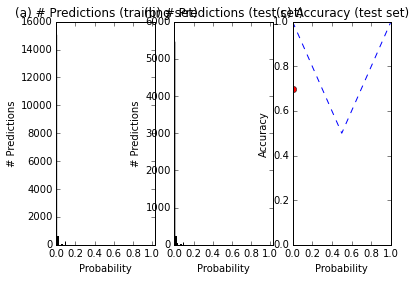

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Corpus Precision nan
Corpus Recall    0.0
Corpus F1        nan
----------------------------------------
TP: 0 | FP: 0 | TN: 4164 | FN: 1818

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Corpus Precision nan
Corpus Recall    0.0
Corpus F1        nan
----------------------------------------
TP: 0 | FP: 0 | TN: 4164 | FN: 3636



In [50]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()

dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates -- Gold').one()

from snorkel.models import CandidateSet
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Development Labels -- Gold')

tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold)

In [51]:
from snorkel.models import Corpus
from snorkel.utils import get_ORM_instance
from hardware_utils import entity_level_f1
import os

dev_corpus = get_ORM_instance(Corpus, session, 'Hardware Development')

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
# NOTE: this is checking on all corpus, not just dev corpus
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware').one()
(TP, FP, FN) = entity_level_f1(tp, fp, tn, fn, gold_file, corpus, 'cb_v_max')

Scoring on Entity-Level Gold Data
Corpus Precision nan
Corpus Recall    0.0
Corpus F1        nan
----------------------------------------
TP: 0 | FP: 0 | FN: 752



In [ ]:
from pprint import pprint
FN_list = sorted(list(FN))
FP_list = sorted(list(FP))
TP_list = sorted(list(TP))
# pprint(FN_list[:])
pprint(FN_list[:10])
# pprint(TP_list[:10])

In [ ]:
# docs = set()
# for doc in corpus.documents:
#     docs.add(doc.name.upper())
# pprint(docs)

In [ ]:
# import itertools
# docs = set()
# for f in itertools.chain.from_iterable([tp, tn, fp, fn]):
#     docs.add(f.part.parent.document.name.upper())
# #     if f.part.parent.document.name.upper() == 'AUKCS04635-1':
# #         print f
# pprint(docs)

In [53]:
sorted(disc_model.get_feature_weights(F_dev))

[(u'LF_cb_keywords_all[-1]', -2.2768049251483147),
 (u'LF_cb_keywords_all[1]', -2.6758445197883716),
 (u'LF_cheating_with_another_part[-1]', -2.2701815526753037),
 (u'LF_equals_in_row[-1]', -1.6330886588272309),
 (u'LF_i_in_row[-1]', -0.9462347563868578),
 (u'LF_low_table_num[-1]', -1.798097816099533),
 (u'LF_not_horz_aligned[-1]', -0.32535094442156903),
 (u'LF_pos_keywords_horz[1]', -0.9775801968669464),
 (u'LF_pos_keywords_in_row[1]', -2.790100368912572),
 (u'LF_same_table_must_align[-1]', -0.32535094442156903),
 (u'LF_specific_neg_row_keywords[-1]', -0.5995288675155236),
 (u'LF_too_many_numbers_row[-1]', -1.4646744603880761),
 (u'LF_voltage_not_in_table[-1]', -3.3206036300442947)]

In [69]:
from hardware_utils import part_error_analysis
c = candidates[100]
print c
print part_error_analysis(c)
print list(get_all_feats(c))
print list(get_row_ngrams(c.voltage, spread=[0,3], n_max=3))

Part_Voltage(ImplicitSpan("BC547A", parent=877, words=[11,13], position=[1]), ImplicitSpan("80", parent=757, words=[0,0], position=[0]))
Doc: Document 112823
------------
Part:
ImplicitSpan("BC547A", parent=877, words=[11,13], position=[1])
Phrase (Doc: 112823, Table: 4, Row: 0, Col: 0, Index: 0, Text: (I C  = 100 mA, V CE  = 5.0 V)                                                 BC547A/548A BC546B/547B/548B)
------------
Attr:
ImplicitSpan("80", parent=757, words=[0,0], position=[0])
Phrase (Doc: 112823, Table: 0, Row: 4, Col: 2, Index: 0, Text: 80)
------------
None
[('LF_cb_keywords_all[1]', 1), ('LF_pos_keywords_in_row[1]', 1)]
[u'collector', u'collector -', u'collector - emitter', u'-', u'- emitter', u'- emitter voltage', u'emitter', u'emitter voltage', u'voltage', u'bc546', u'v', u'v ceo', u'ceo', u'65', u'vdc', u'bc547', u'45', u'bc548', u'30', u'collector', u'collector -', u'collector - base', u'-', u'- base', u'- base voltage', u'base', u'base voltage', u'voltage', u'bc546', u

In [ ]:
from hardware_utils import entity_to_candidates, part_error_analysis

entity = FN_list[0]
matches = entity_to_candidates(entity, dev)
print "Entity: (%d matches)" % len(matches)
print entity


In [ ]:
from hardware_utils import entity_to_candidates, part_error_analysis

# disc_model.get_feature_weights(F_dev)

entity = FN_list[0]
matches = entity_to_candidates(entity, dev)
print "Entity: (%d matches)" % len(matches)
print entity

stop = False
for i, c in enumerate(matches):
    part_error_analysis(c)
    results = []
    for lf in LFs:
        name = lf.__name__
        result = lf(c)
        results.append((name, result))
#         if name == 'LF_cb_keywords_all' and result == -1:
#             print name
#             ngrams = list(get_row_ngrams(c.voltage, spread=[0,3], n_max=3))
#             print ngrams
#             print overlap(ngrams, cb_words)
#             stop = False
#         if name == 'LF_cheating_with_another_part' and result == -1:
#             print name
#             horz_ngrams = list(get_horz_ngrams(c))
#             print horz_ngrams
#             print [part_sniffer.match(x) for x in horz_ngrams]
#             stop = False
        if name == 'LF_i_in_row' and result == -1:
            print name
            ngrams = list(get_row_ngrams(c.voltage, spread=[0,3], n_max=3))
            print ngrams
            stop = False
        if stop: break
    print "MATCH %d:" % i
    print heuristic(c)
    pprint(results)
    print "--------------------------------------------------------------------------------"
    if stop: break
    
#     if heuristic(candidate):
#         print "\nCandidate:"
# #         print candidate
#         print part_error_analysis(candidate)
#     print heuristic(candidate)
#     print LF_voltage_not_in_table(candidate)
#         print candidate.voltage.parent.table
#     print "\nScore:"
#     print disc_model.get_candidate_score(candidate, F_dev)

#     print "\nFeatures:"
#     pprint(disc_model.get_candidate_feature_weights(candidate, F_dev))

In [ ]:
# def LF_first_row(c):
#     if c.voltage.parent.row_num == 0:
#         return -1
#     else:
#         return 0
# LFs.append(LF_first_row)
    
# def LF_not_ce_relevant(c):
#     ce_keywords = set(['collector', 'emitter', 'collector-emitter'])
#     ngrams = set(get_aligned_ngrams(c.voltage))
#     if not set_any_in_set(ce_keywords, ngrams):
#         return -1
#     else:
#         return 1
# LFs.append(LF_not_ce_relevant)

# def LF_negative_keywords(c):
#     row_neg_keys = set(['ambient',
#                     'small-signal',
#                     'cut-off',
#                     'na',
#                     'ma',
#                     'cex',
#                     'resistance',
#                     'power',
#                     'junction',
#                     'dissipation', 
#                     'breakdown',
#                     'current',
#                     'ceo',
#                     'vceo'
#                     'peak',
#                     '=',
#                     'f',
#                     'p',
#                     'base',
#                     'mw',
#                     'ebo',
#                     'vebo',
#                     'i c',
#                     'total',
#                     'device',
#                     'c',
#                     'mhz',
#                     'temperature',
#                     'saturation',
#                     'operating',
#                     'storage'
#                     'bandwidth',
#                     'derate',
#                     'above',
#                     'product',
#                     'figure',
#                     'conditions',
#                     'current gain',
#                     'saturation',
#                     'min',
#                     'min.',
#                     'typ',
#                     'typ.',
#                     'max',
#                     'max.',
#                     'gain',
#                     'p',
#                     'thermal',
#                     'test'])
#     row_ngrams = set(get_row_ngrams(c.voltage))
#     col_ngrams = set(get_col_ngrams(c.voltage))
#     col_neg_keys = set(['conditions', 
#                         'condition', 
#                         'parameter', 
#                         'min',
#                         'min.',
#                         'typ',
#                         'typ.',
#                         'max',
#                         'max.',
#                         'test'])
#     if set_any_in_set(row_neg_keys, row_ngrams):
#         return -1
#     if set_any_in_set(col_neg_keys, col_ngrams):
#         return -1
#     return 0
# LFs.append(LF_negative_keywords)
    
# def LF_negative_keywords_in_col(c):
#     neg_keys = set(['conditions',
#                     'condition',
#                     'parameter',
#                     'test'])
#     ngrams = set(get_col_ngrams(c.voltage))
#     if set_any_in_set(neg_keys, ngrams):
#         return -1
#     else:
#         return 0

# LFs.append(LF_negative_keywords_in_col)

# def LF_negative_keywords_in_part_aligned(c):
#     ngrams = set(get_aligned_ngrams(c.part))
#     return -1 if (
#         'gain'          in ngrams or
#         'small-signal'  in ngrams or
#         'small'         in ngrams or
#         'cbo'         in ngrams or
#         'collector-emitter' in ngrams or
#         'value'         in ngrams or
#         'thermal'       in ngrams) else 0
# LFs.append(LF_negative_keywords_in_part_aligned)

# def LF_negative_keywords(c):
#     ngrams = set(get_aligned_ngrams(c.voltage))
#     return -1 if (
#         'collector-base'    in ngrams or
#         'cut-off'           in ngrams or
#         '='                 in ngrams or
#         'gain'              in ngrams or
#         'h fe'              in ngrams or
#         'typ.'              in ngrams or
#         'typ'               in ngrams or
#         'min'               in ngrams or
#         'min.'              in ngrams or
#         'saturation'        in ngrams or
#         'mhz'               in ngrams or
#         'gain'              in ngrams or
#         'obo'               in ngrams or
#         'c obo'             in ngrams) else 0
# LFs.append(LF_negative_keywords)
